In [ ]:
Machine Learning Semester Project: Student Performance Prediction

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

# Set seaborn style for visualizations
sns.set(style="whitegrid")

In [ ]:
# 2. Data Collection
# Load the dataset (assuming 'StudentsPerformance.csv' is downloaded from Kaggle)
df = pd.read_csv('StudentsPerformance.csv')

# Dataset description
print("Dataset Source: Kaggle - Students Performance in Exams")
print("Size:", df.shape)
print("Features:", df.columns.tolist())
print("First few rows:")
print(df.head())

# Save a copy if needed (for cleaned dataset deliverable)
df.to_csv('original_dataset.csv', index=False)

Dataset Source: Kaggle - Students Performance in Exams
Size: (1000, 8)
Features: ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course', 'math score', 'reading score', 'writing score']
First few rows:
   gender race/ethnicity parental level of education         lunch  \
0  female        group B           bachelor's degree      standard   
1  female        group C                some college      standard   
2  female        group B             master's degree      standard   
3    male        group A          associate's degree  free/reduced   
4    male        group C                some college      standard   

  test preparation course  math score  reading score  writing score  
0                    none          72             72             74  
1               completed          69             90             88  
2                    none          90             95             93  
3                    none          47             57      

In [ ]:
# Check for missing values
print("Missing values:\n", df.isnull().sum())

# Remove duplicates
df = df.drop_duplicates()
print("Shape after removing duplicates:", df.shape)

# Handle outliers (e.g., clip scores to 0-100)
for col in ['math score', 'reading score', 'writing score']:
    df[col] = np.clip(df[col], 0, 100)

# Feature Engineering: Create 'prepared' binary from 'test preparation course'
df['prepared'] = df['test preparation course'].apply(lambda x: 1 if x == 'completed' else 0)

# Drop unnecessary columns if any (e.g., keep all for now)
# Split features and target
X = df.drop(['math score', 'reading score', 'writing score'], axis=1)  # Predict math score, drop other scores
y = df['math score']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ])

# Apply preprocessing (we'll use in pipeline later)
# Explain decisions: Standardization for numerical features to improve model performance; One-hot for categories to avoid ordinal assumptions.

# Save cleaned dataset
df_cleaned = pd.concat([X, y], axis=1)
df_cleaned.to_csv('cleaned_dataset.csv', index=False)
print("Cleaned dataset saved as 'cleaned_dataset.csv'")

Missing values:
 gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64
Shape after removing duplicates: (1000, 8)
Cleaned dataset saved as 'cleaned_dataset.csv'


Descriptive Statistics:
        math score  reading score  writing score     prepared
count  1000.00000    1000.000000    1000.000000  1000.000000
mean     66.08900      69.169000      68.054000     0.358000
std      15.16308      14.600192      15.195657     0.479652
min       0.00000      17.000000      10.000000     0.000000
25%      57.00000      59.000000      57.750000     0.000000
50%      66.00000      70.000000      69.000000     0.000000
75%      77.00000      79.000000      79.000000     1.000000
max     100.00000     100.000000     100.000000     1.000000


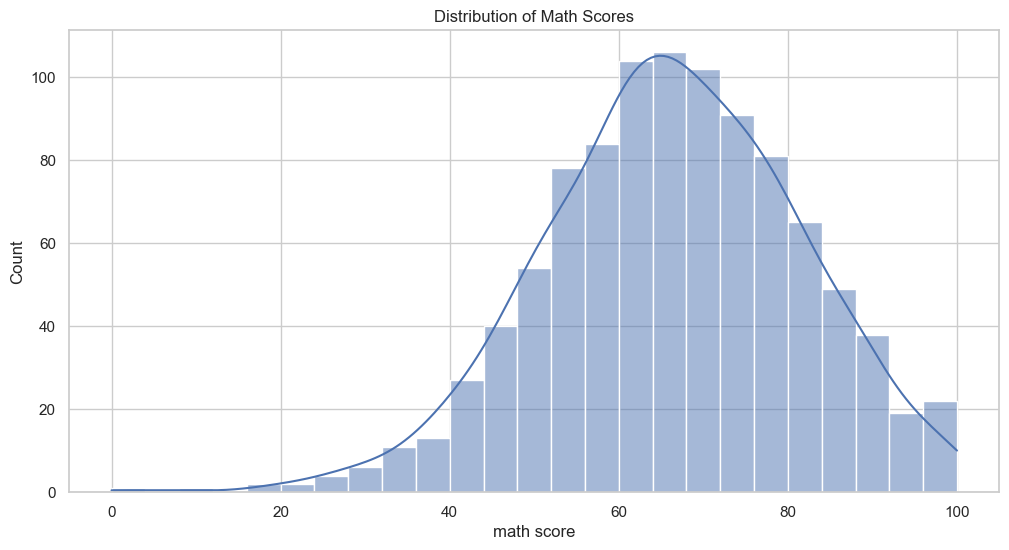

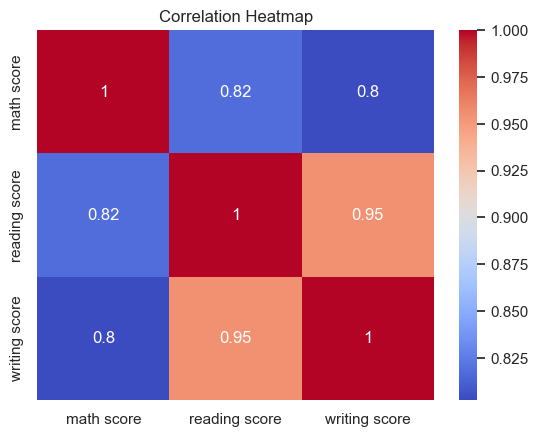

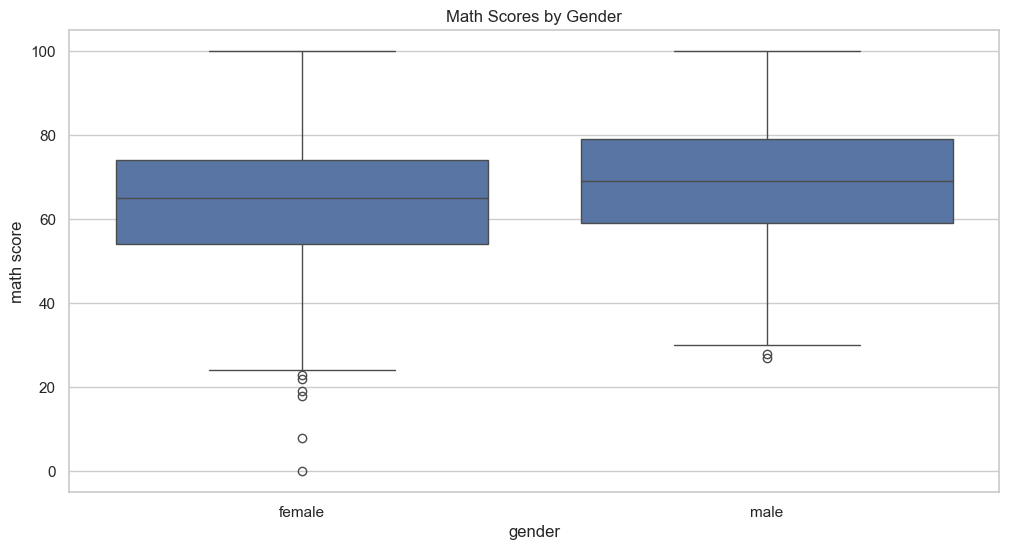

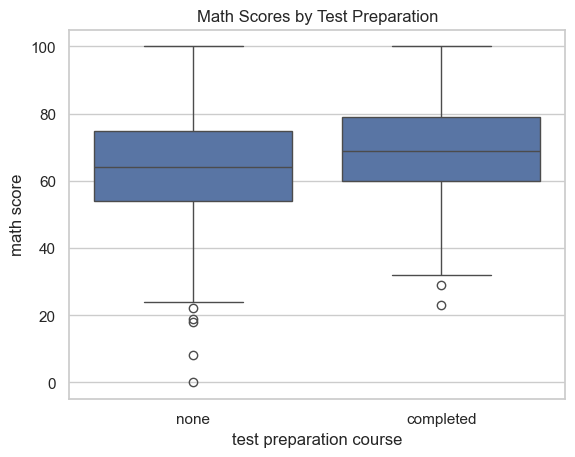

In [9]:
# Statistical Summaries
print("Descriptive Statistics:\n", df.describe())

# Distributions
plt.figure(figsize=(12, 6))
sns.histplot(df['math score'], kde=True)
plt.title('Distribution of Math Scores')
plt.show()

# Correlations (numerical only for simplicity)
corr = df[['math score', 'reading score', 'writing score']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Boxplots for categorical features vs target
plt.figure(figsize=(12, 6))
sns.boxplot(x='gender', y='math score', data=df)
plt.title('Math Scores by Gender')
plt.show()

sns.boxplot(x='test preparation course', y='math score', data=df)
plt.title('Math Scores by Test Preparation')
plt.show()

# Insights: Males tend to score higher in math; Test prep improves scores. Correlations show reading/writing relate to math.

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Baseline Model: Linear Regression
baseline_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

baseline_pipeline.fit(X_train, y_train)
y_pred_baseline = baseline_pipeline.predict(X_test)

# Improved Model: Random Forest with Grid Search
improved_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

# Hyperparameter Tuning
param_grid = {
    'model__n_estimators': [50, 100],
    'model__max_depth': [None, 10, 20]
}
grid_search = GridSearchCV(improved_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
y_pred_improved = best_model.predict(X_test)

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'model__max_depth': 10, 'model__n_estimators': 100}


Baseline (Linear Regression) - RMSE: 14.16, MAE: 11.27, R²: 0.18
Improved (Random Forest) - RMSE: 15.55, MAE: 12.23, R²: 0.01


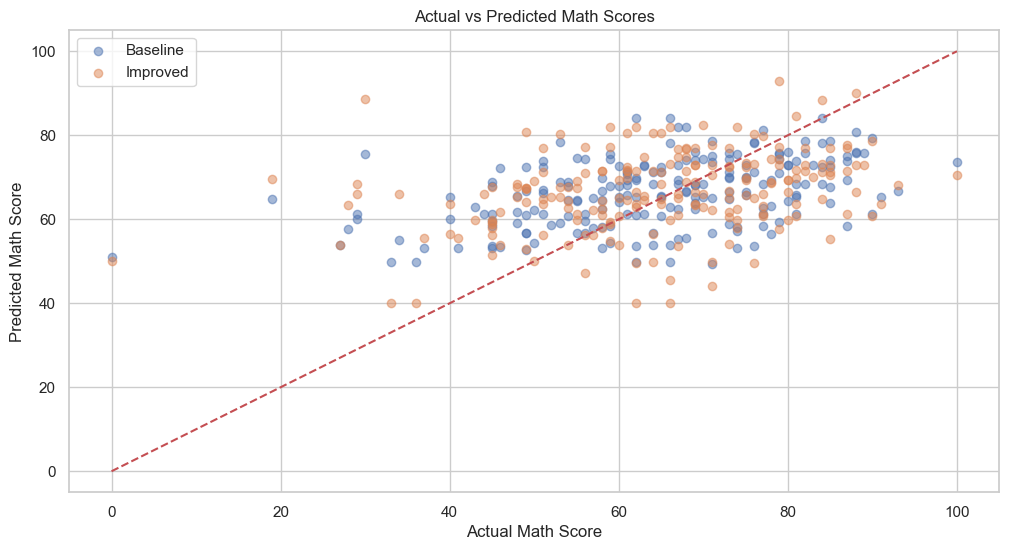

In [ ]:
# Evaluation Function
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - RMSE: {rmse:.2f}, MAE: {mae:.2f}, R²: {r2:.2f}")
    return rmse, mae, r2

# Evaluate Baseline
evaluate_model(y_test, y_pred_baseline, "Baseline (Linear Regression)")

# Evaluate Improved
evaluate_model(y_test, y_pred_improved, "Improved (Random Forest)")

# Visualizations
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred_baseline, alpha=0.5, label='Baseline')
plt.scatter(y_test, y_pred_improved, alpha=0.5, label='Improved')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual Math Score')
plt.ylabel('Predicted Math Score')
plt.title('Actual vs Predicted Math Scores')
plt.legend()
plt.show()

# Comparison: Improved model has lower RMSE/MAE and higher R², showing better performance.